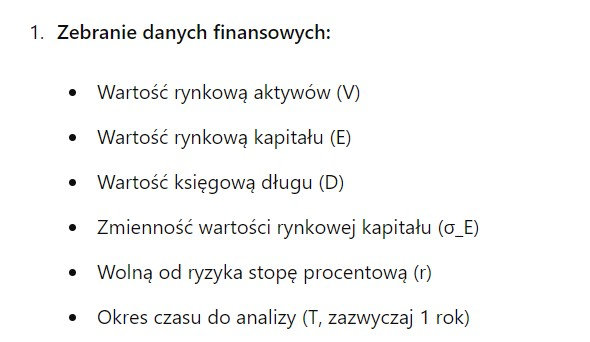

# Firma COFCO (dostawca cukru)

In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

In [36]:



ticker = '600737.SS'
data = yf.Ticker(ticker)

market_data = data.history(period="1y")
current_price = market_data['Close'][-1]
shares_outstanding = data.info['sharesOutstanding']

E = current_price * shares_outstanding # wartość rynkowa kapitału

D = data.info['totalDebt'] # wartość księgowa długu

market_data['Daily Return'] = market_data['Close'].pct_change() 
daily_volatility = market_data['Daily Return'].std()

annual_volatility = daily_volatility * np.sqrt(252)
sigma_E = annual_volatility

r = 0.0517 # wolna od ryzyka stopa procentowa (aktualne stopy procentowe dla obligacji skarbowych USA na stronie internetowej US Treasury (Departament Skarbu USA))

T = 1 # 

print(f"Wartość rynkowa kapitału (E): {E} USD")
print(f"Wartość księgowa długu (D): {D} USD")
print(f"Volatility of Market Value of Equity (σ_E): {sigma_E}")
print(f"Risk-Free Interest Rate (r): {r}")
print(f"Time Period (T): {T} year")

Wartość rynkowa kapitału (E): 23014027006.023926 USD
Wartość księgowa długu (D): 6549996032 USD
Volatility of Market Value of Equity (σ_E): 0.28195858491486153
Risk-Free Interest Rate (r): 0.0517
Time Period (T): 1 year


In [37]:
print("Dzienne zwroty:")
print(market_data['Daily Return'])


# Obliczenie zmienności dziennych zwrotów
daily_volatility = market_data['Daily Return'].std()

# Przeskalowanie do zmienności rocznej
annual_volatility = daily_volatility * np.sqrt(252) # 252 dni to liczba handlowych dni w roku
sigma_E = annual_volatility

print("\n")
print(f"Zmienność dzienna zwrotów: {daily_volatility}")
print(f"Zmienność roczna zwrotów (sigma_E): {annual_volatility}")


Dzienne zwroty:
Date
2023-06-07 00:00:00+08:00         NaN
2023-06-08 00:00:00+08:00    0.007547
2023-06-09 00:00:00+08:00    0.078652
2023-06-12 00:00:00+08:00   -0.018519
2023-06-13 00:00:00+08:00   -0.003538
                               ...   
2024-06-03 00:00:00+08:00   -0.006856
2024-06-04 00:00:00+08:00    0.087771
2024-06-05 00:00:00+08:00   -0.020852
2024-06-06 00:00:00+08:00   -0.000926
2024-06-07 00:00:00+08:00   -0.002780
Name: Daily Return, Length: 243, dtype: float64


Zmienność dzienna zwrotów: 0.017761721326295513
Zmienność roczna zwrotów (sigma_E): 0.28195858491486153


In [38]:

# Funkcja do iteracyjnego oszacowania wartości rynkowej aktywów (V) i ich zmienności (σ_V)
def oszacuj_v_sigma(E, D, sigma_E, r, T):
    def rownania(p):
        V, sigma_V = p
        d1 = (np.log(V/D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
        d2 = d1 - sigma_V * np.sqrt(T)
        eq1 = E - (V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2))
        eq2 = sigma_E - (V * norm.cdf(d1) * sigma_V) / E
        return (eq1, eq2)
    
    V_initial = E + D
    sigma_V_initial = sigma_E * (E / (E + D))
    V, sigma_V = fsolve(rownania, (V_initial, sigma_V_initial))
    return V, sigma_V

# Funkcja do obliczenia prawdopodobieństwa defaultu (PD)
def oblicz_pd(E, D, sigma_E, r, T):
    V, sigma_V = oszacuj_v_sigma(E, D, sigma_E, r, T)
    d1 = (np.log(V/D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    dd = (np.log(V/D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    PD = norm.cdf(-dd)
    return PD, V, sigma_V

# Obliczanie PD dla Cofco
PD_bc, V_bc, sigma_V_bc = oblicz_pd(E, D, sigma_E, r, T)


print(f"Prawdopodobieństwo Defaultu (PD): {PD_bc:.4g}")
print(f"Wartość Rynkowa Aktywów (V): {V_bc:.4g}")

print(f"Zmienność Wartości Rynkowej Aktywów (σ_V): {sigma_V_bc:.4g}")



Prawdopodobieństwo Defaultu (PD): 3.417e-12
Wartość Rynkowa Aktywów (V): 2.923e+10
Zmienność Wartości Rynkowej Aktywów (σ_V): 0.222


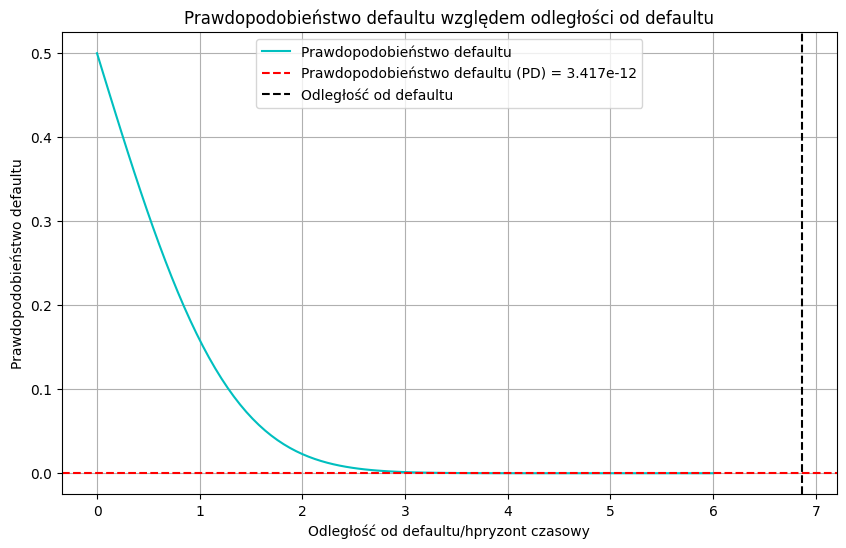

In [58]:

# Wykres prawdopodobieństwa defaultu względem odległości od defaultu
default_distance = np.linspace(0, 6, 100)
probability_of_default = norm.cdf(-default_distance)

plt.figure(figsize=(10, 6))
plt.plot(default_distance, probability_of_default, label='Prawdopodobieństwo defaultu', c="c")
plt.axhline(y=PD_bc, color='r', linestyle='--', label=f'Prawdopodobieństwo defaultu (PD) = {PD_bc:.4g}')
plt.axvline(x=(np.log(V_bc/D) + (r - 0.5 * sigma_V_bc**2) * T) / (sigma_V_bc * np.sqrt(T)), color='k', linestyle='--', label='Odległość od defaultu')
plt.xlabel('Odległość od defaultu/hpryzont czasowy')
plt.ylabel('Prawdopodobieństwo defaultu')
plt.title('Prawdopodobieństwo defaultu względem odległości od defaultu')
plt.legend()
plt.grid()
plt.savefig('Prawdopodobieństwo defaultu względem odległości od defaultu dla COFCO')
plt.show()
